<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Цели проекта
Построение и выбор модели для прогноза количества заказов такси на следующий час.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import catboost
 
from numpy.random import RandomState
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
# читаем данные из .csv файла с помощью метода read_csv()
try:
    df = pd.read_csv('D:\\python\\project_12\\taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

# с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


- В таблице 26496 столбцов
- Тип данных object в столбце datetime нужно привести к типу datetime. Передадим в функцию read_csv() аргумент parse_dates (англ. «разобрать даты»).
- Установим индекс таблицы равным столбцу datetime. Функции read_csv() передаем аргумент index_col (от англ. index column, «индексирующий столбец»)

In [4]:
# читаем данные из .csv файла с помощью метода read_csv()
try:
    df = pd.read_csv('D:\\python\\project_12\\taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Посмотрим вновь на содержимое таблицы.

In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
df.duplicated().sum()

26415

Проверка на дубликаты ничего не дает, так как по сути у нас тут один столбец.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


В среднем мы имеем 13-14 заказов каждые 10 минут. Максимум 119.

<AxesSubplot:>

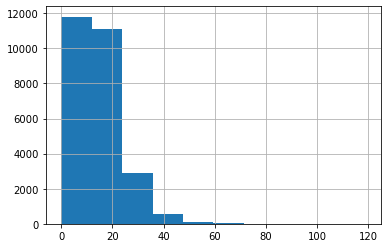

In [8]:
df['num_orders'].hist()

Большинство заказов распределено в количестве до 40.

Проверим есть ли пропуски в таблице.

In [9]:
df.isna().sum()

num_orders    0
dtype: int64

- Отсортируем индексы таблицы.
- Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic (англ. «монотонный»).

In [10]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


Порядок соблюдён.

Посмотрим на тренды заказов в нашей выборке в месяцы 2018 года.

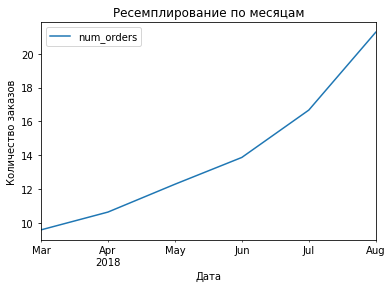

In [11]:
df.resample('1M').mean().plot()
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Ресемплирование по месяцам');

Количество заказов с каждым месяцем только росло и за пол года показатели выросли более чем в 2 раза. Серьезный результат. Можно предположить, что в этот период монополисты как раз занимались уничтожением конкурентов. То есть цифровые платформы занимались "освоением новых рынков".

Выполним ресемплирование(изменение интервала со значениями ряда) по одному часу. 

In [12]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим график временного ряда.

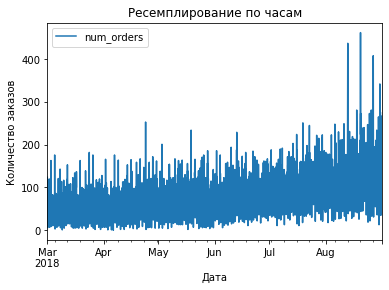

In [13]:
df.plot()
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Ресемплирование по часам');

Не слишком информативно, хотя и заметен тренд на увеличение количества заказов, но необходим дальнейший анализ.

## Анализ

- Разделим временной ряд на тренд, сезонность и остаток(шум). 
- Построим графики временного ряда.

In [14]:
decomposed = seasonal_decompose(df)

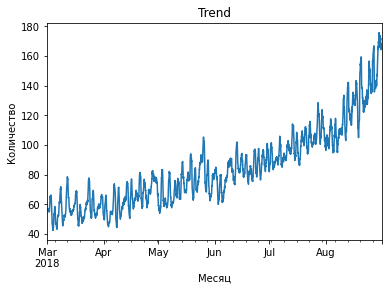

In [15]:
decomposed.trend.plot()
plt.title('Trend')
plt.xlabel('Месяц')
plt.ylabel('Количество');

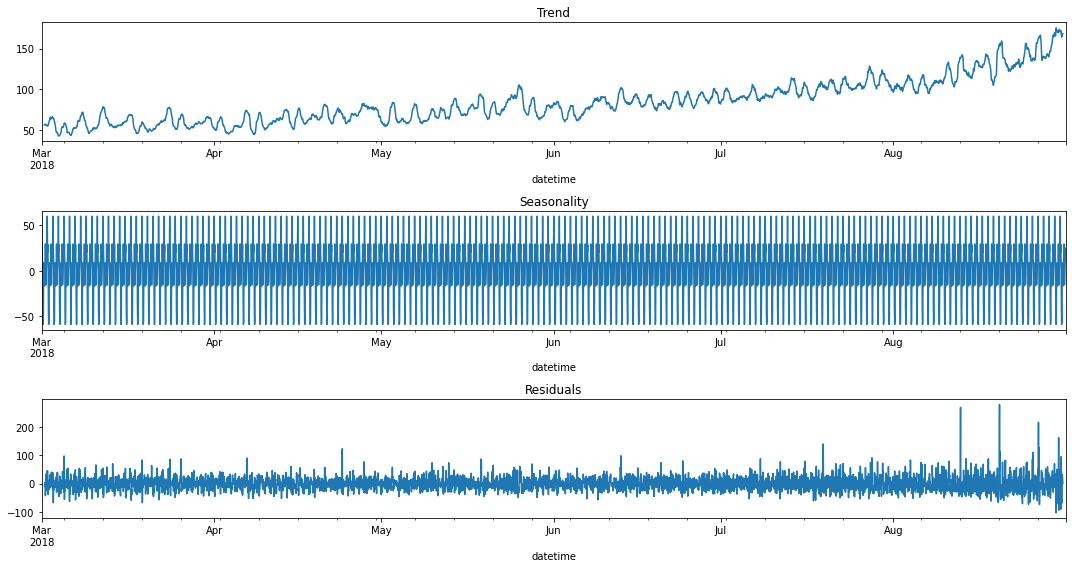

In [16]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Как мы ранее подметили, очевидно, что заметен тренд на увеличение количества заказов с марта по август 2018 года. 
- На сезонность лучше взглянуть подробнее, например в первой половине июня.
- Сезонность - циклично повторяющиеся закономерности во временном ряду. И на графике похоже на то, что каждый месяц эти циклы прослеживаются ежедневно.

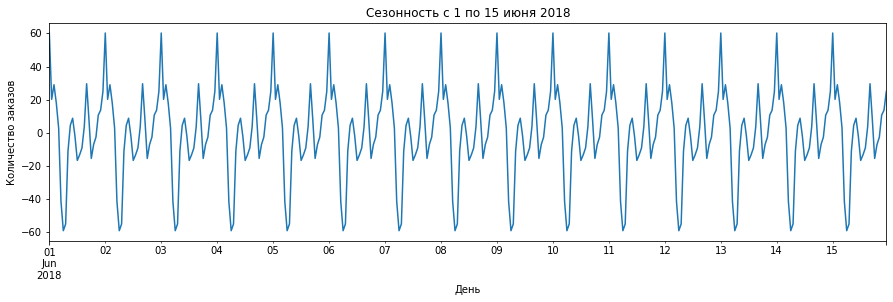

In [17]:
plt.figure(figsize=(15, 4))
decomposed.seasonal['2018-06-01':'2018-06-15'].plot()
plt.title('Сезонность с 1 по 15 июня 2018')
plt.xlabel('День')
plt.ylabel('Количество заказов');

- Стохастический процесс стационарный - распределение периодических колебаний значений со временем не меняется.
- Ежедневно наблюдаем пики и спады заказов в определенное время. Посмотрим в разрезе часов на день.

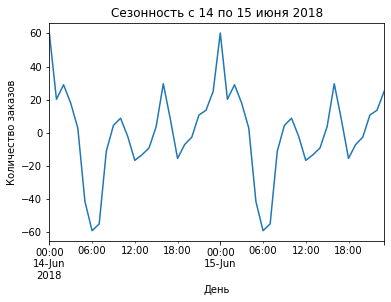

In [18]:
decomposed.seasonal['2018-06-14':'2018-06-15'].plot()
plt.title('Сезонность с 14 по 15 июня 2018')
plt.xlabel('День')
plt.ylabel('Количество заказов');

Похоже на то, что ежедневно люди заказывают такси в рабочее время и после работы. А ближе к полуночи возвращаются домой и на это время приходится большинство заказов. Ночью количество заказов до 6 утра только снижается.

Посмотрим на скользящее среднее и скользящее стандартное отклонение

<AxesSubplot:xlabel='datetime'>

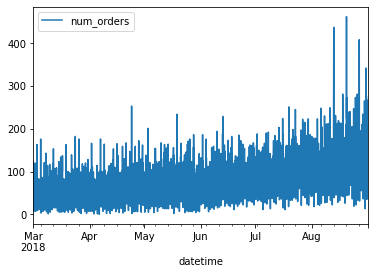

In [19]:
#df['mean'] = df['num_orders'].rolling(25).mean()
#df['std'] = df['num_orders'].rolling(25).std()
df.plot()

## Обучение

- Напишем функцию для создания обучающих признаков для обучения моделей
- Добавим в нее календарные признаки - месяц, день недели и час, month, day, dayofweek
- Отстающие значения lag за 24 часа
- скользящее среднее rolling_mean за каждые 6 часов 

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['month'] = data_copy.index.month   
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_copy

df_lag = make_features(df, 24, 4)
df_lag.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


- Разделим данные о количестве заказов такси на обучающую и тестовую выборки в соотношении 9:1. Возьмем данные за доступное время.
- Напечатаем на экране минимальные и максимальные значения индексов выборок, чтобы убедиться в корректности деления.

In [21]:
train, test = train_test_split(df_lag, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


- Данные разделены корректно - 5 месяцев на 9 к 1.

In [22]:
train.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


In [23]:
print('Размер обучающей выборки: ', train.shape)
print('Размер тестовой выборки: ', test.shape)

Размер обучающей выборки:  (3974, 29)
Размер тестовой выборки:  (442, 29)


Удаляем строки с пропусками

In [24]:
train = train.dropna()

In [25]:
print('Размер обучающей выборки: ', train.shape)

Размер обучающей выборки:  (3950, 29)


В выборке выделим признаки и целевой признак (количество заказов).

In [26]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [27]:
features_train

,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.50
2018-03-02 01:00:00,3,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,81.75
2018-03-02 02:00:00,3,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,95.25
2018-03-02 03:00:00,3,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,85.75
2018-03-02 04:00:00,3,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,87.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,8,0,9,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,69.75
2018-08-13 10:00:00,8,0,10,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,83.25
2018-08-13 11:00:00,8,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,105.75


### LinearRegression

In [28]:
model_lr = LinearRegression()

In [29]:
model_lr.fit(features_train, target_train)
preds_train = model_lr.predict(features_train)
print("RMSE на обучающей выборке, число заказов:", mean_squared_error(target_train, preds_train) **.5)

preds_test = model_lr.predict(features_test)
print("RMSE на тестовой выборке, число заказов: ", mean_squared_error(target_test, preds_test) ** .5)

RMSE на обучающей выборке, число заказов: 25.743895530209972
RMSE на тестовой выборке, число заказов:  45.67925689462977


Попробуем улучшить результат

In [30]:
cv_results = cross_validate(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5)

In [31]:
cv_results

{'fit_time': array([0.01004601, 0.01006269, 0.00202227, 0.        , 0.        ]),
 'score_time': array([0.01008034, 0.00800633, 0.00802898, 0.00803828, 0.00802541]),
 'test_score': array([-21.83933145, -22.8299396 , -25.21907001, -25.81310786,
        -33.23192912])}

Во избежание утечки целевого признака воспользуемся TimeSeriesSplit

In [32]:
cv_split = TimeSeriesSplit(n_splits=6)

In [33]:
params_lr = {"normalize": [True, False],"fit_intercept" : [True, False]}                        


grid_search = GridSearchCV(model_lr, n_jobs = -1, param_grid = params_lr, cv = cv_split,
                           scoring = "neg_root_mean_squared_error", verbose = 3)
grid_search.fit(features_train,target_train)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [34]:
grid_search.cv_results_

{'mean_fit_time': array([0.01139744, 0.01140316, 0.00805092, 0.009384  ]),
 'std_fit_time': array([0.00551927, 0.00321285, 0.00367741, 0.00527768]),
 'mean_score_time': array([0.00369004, 0.00269381, 0.00536819, 0.00269039]),
 'std_score_time': array([0.00392045, 0.00342806, 0.00474139, 0.00341761]),
 'param_fit_intercept': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_normalize': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'fit_intercept': True, 'normalize': True},
  {'fit_intercept': True, 'normalize': False},
  {'fit_intercept': False, 'normalize': True},
  {'fit_intercept': False, 'normalize': False}],
 'split0_test_score': array([-2.33530370e+01, -1.47918052e+08, -2.34143038e+01, -2.34143038e+01]),
 'split1_test_score': array([-24.47263982, -24.47203865, -24.3

In [35]:
test_score_lr = abs(cv_results['test_score'].mean())

In [36]:
test_score_lr

25.78667560899396

### LightGBMRegression

In [37]:
categorial = ['month','dayofweek','hour']

for column in categorial:
    features_train[column] = features_train[column].astype('category')
    features_test[column] = features_test[column].astype('category')
    
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   month         3950 non-null   category
 1   dayofweek     3950 non-null   category
 2   hour          3950 non-null   category
 3   lag_1         3950 non-null   float64 
 4   lag_2         3950 non-null   float64 
 5   lag_3         3950 non-null   float64 
 6   lag_4         3950 non-null   float64 
 7   lag_5         3950 non-null   float64 
 8   lag_6         3950 non-null   float64 
 9   lag_7         3950 non-null   float64 
 10  lag_8         3950 non-null   float64 
 11  lag_9         3950 non-null   float64 
 12  lag_10        3950 non-null   float64 
 13  lag_11        3950 non-null   float64 
 14  lag_12        3950 non-null   float64 
 15  lag_13        3950 non-null   float64 
 16  lag_14        3950 non-null   float64 
 17  lag_15  

In [38]:
model_lgbmr = LGBMRegressor()

In [39]:
parameters = [{'learning_rate': [0.01, 0.1],
                       'n_estimators': [50, 100, 200],
                       'num_leaves': [15, 30, 50]}]

cv_split_lgbmr = TimeSeriesSplit(n_splits=6).split(features_train)

In [40]:
grid_search = GridSearchCV(model_lgbmr, 
                           n_jobs = 1, 
                           param_grid = parameters, 
                           cv = cv_split_lgbmr, 
                           scoring = "neg_root_mean_squared_error", 
                           verbose = 5)
grid_search.fit(features_train,target_train)

Fitting 6 folds for each of 18 candidates, totalling 108 fits
[CV 1/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-24.229 total time=   0.0s
[CV 2/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-29.493 total time=   0.0s
[CV 3/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-31.942 total time=   0.0s
[CV 4/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-29.438 total time=   0.0s
[CV 5/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-36.472 total time=   0.0s
[CV 6/6] END learning_rate=0.01, n_estimators=50, num_leaves=15;, score=-47.368 total time=   0.0s
[CV 1/6] END learning_rate=0.01, n_estimators=50, num_leaves=30;, score=-24.220 total time=   0.0s
[CV 2/6] END learning_rate=0.01, n_estimators=50, num_leaves=30;, score=-29.282 total time=   0.0s
[CV 3/6] END learning_rate=0.01, n_estimators=50, num_leaves=30;, score=-31.603 total time=   0.1s
[CV 4/6] END learning_rate=0.01, n_estimators=5

[CV 5/6] END learning_rate=0.1, n_estimators=100, num_leaves=30;, score=-26.469 total time=   0.1s
[CV 6/6] END learning_rate=0.1, n_estimators=100, num_leaves=30;, score=-31.148 total time=   0.2s
[CV 1/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-22.683 total time=   0.0s
[CV 2/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-24.194 total time=   0.1s
[CV 3/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-23.349 total time=   0.2s
[CV 4/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-22.982 total time=   0.2s
[CV 5/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-26.011 total time=   0.2s
[CV 6/6] END learning_rate=0.1, n_estimators=100, num_leaves=50;, score=-30.885 total time=   0.3s
[CV 1/6] END learning_rate=0.1, n_estimators=200, num_leaves=15;, score=-23.302 total time=   0.0s
[CV 2/6] END learning_rate=0.1, n_estimators=200, num_leaves=15;, score=-23.703 total time=   0.1s
[CV 3/6] E

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000014958F99190>,
             estimator=LGBMRegressor(), n_jobs=1,
             param_grid=[{'learning_rate': [0.01, 0.1],
                          'n_estimators': [50, 100, 200],
                          'num_leaves': [15, 30, 50]}],
             scoring='neg_root_mean_squared_error', verbose=5)

In [41]:
best_index = grid_search.best_index_

In [42]:
test_score_grid = abs(grid_search.cv_results_['mean_test_score'][best_index])

In [43]:
best_estimator = grid_search.best_estimator_

In [44]:
print('Качество модели, метрика RMSE, число заказов: {}'.format(test_score_grid.round(1)))

Качество модели, метрика RMSE, число заказов: 24.9


LGBMRegressor показал чуть лучший результат метрики RMSE, воспользуемся его результатами, хотя с учетом сложности настройки гиперпараметров это нецелесообразно и LinearRegression представляется более оптимальным вариантом. Тем не менее тестируем модель на LGBMRegressor.

## Тестирование

In [45]:
def rmse(target, predictions):
    rmse = mean_squared_error(target, predictions)**.5
    return rmse

In [46]:
predictions_lgbmr = grid_search.predict(features_test)

rmse_lgbmr = rmse(target_test, predictions_lgbmr)

print('RMSE LGBMRegressor на тестовой выборке:', rmse_lgbmr)

RMSE LGBMRegressor на тестовой выборке: 40.57328391869956


Исходя из условий поставленной задачи значение метрики RMSE на тестовой выборке должно быть не больше 48, и наше значение удовлетворяет условию.

Посмотрим важность признаков у модели LGBMRegressor

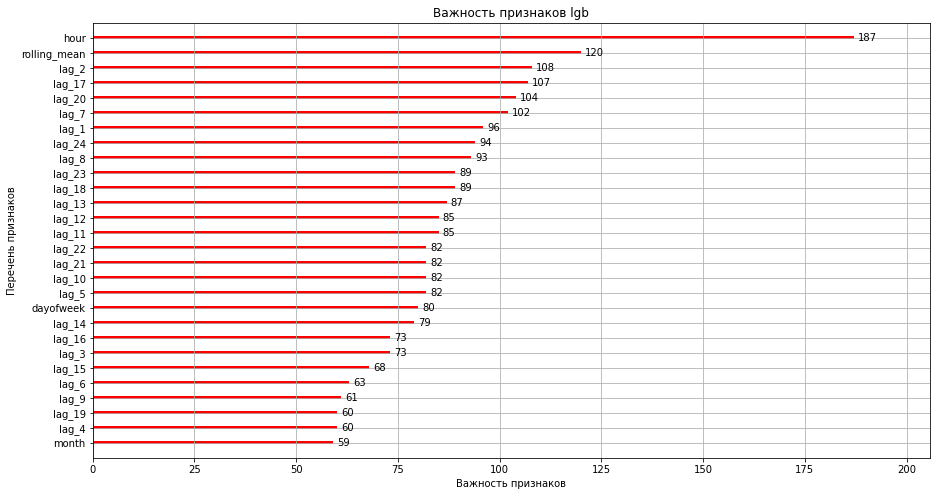

In [47]:
import lightgbm as lgb
feature_importance = lgb.plot_importance(best_estimator, 
                                         color='r', 
                                         title='Важность признаков lgb', 
                                         xlabel='Важность признаков', 
                                         ylabel='Перечень признаков', 
                                         figsize=(15, 8))

Самый важный признак это hour, хотя это было заметно и из анализа данных, а также понятно интуитивно.

### Проверка DummyRegressor

In [48]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_train)

predictions_dummy = dummy.predict(features_test)

print('RMSE DummyRegressor на тестовой выборке:', rmse(target_test, predictions_dummy))

RMSE DummyRegressor на тестовой выборке: 84.6499381993622


- Метрика RMSE DummyRegressor на тестовой выборке оказалась значительно ниже остальных обученных моделей.

- Следовательно наши обученные модели адекватны.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48